#Human Or Horses Image Classifier

###Loading dataset

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

--2021-01-14 09:58:02--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.217.9.208, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   209MB/s    in 0.7s    

2021-01-14 09:58:03 (209 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



###Extracting The Data

In [ ]:
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
zip_ref.close()

###Dataset Info

In [ ]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

####Viewing Directory

In [ ]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

['horse04-3.png', 'horse12-5.png', 'horse06-9.png', 'horse27-4.png', 'horse13-6.png', 'horse30-6.png', 'horse41-8.png', 'horse18-4.png', 'horse22-4.png', 'horse01-2.png']
['human04-20.png', 'human12-29.png', 'human05-07.png', 'human06-24.png', 'human03-22.png', 'human10-28.png', 'human02-02.png', 'human11-18.png', 'human10-20.png', 'human07-20.png']


In [ ]:
#Total no. of training images
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

total training horse images: 500
total training human images: 527


####Viewing Few images

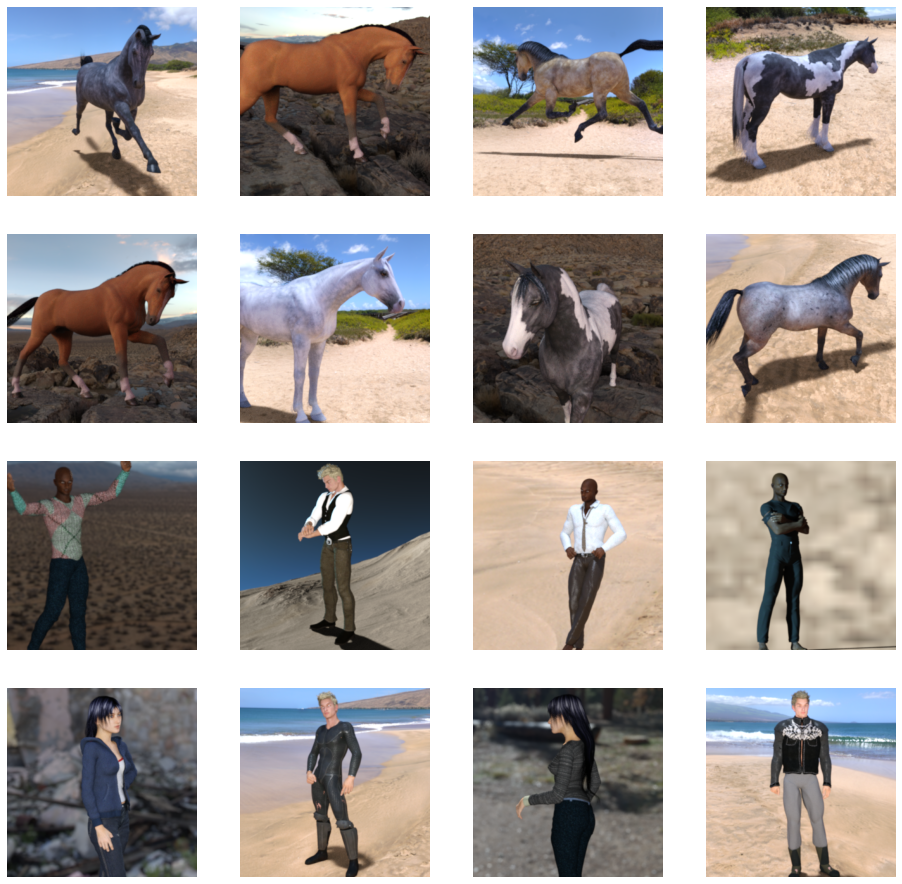

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

###Building Model


In [ ]:
import tensorflow as tf
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

###Data Prepocessing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/tmp/horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1027 images belonging to 2 classes.


###Adding Callback to stop training if Accuracy > 98%

In [ ]:
class Mycallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if (logs.get('accuracy') > 0.98):
      print("Reached 98% .... Stopping Training")
      self.model.stop_training = True

###Training

In [ ]:
callbacks = Mycallback()
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1,
      callbacks = [callbacks])

Epoch 1/15
8/8 [==============================] - 13s 647ms/step - loss: 0.8818 - accuracy: 0.5214
Epoch 2/15
8/8 [==============================] - 6s 712ms/step - loss: 0.5836 - accuracy: 0.6972
Epoch 3/15
8/8 [==============================] - 6s 715ms/step - loss: 0.5594 - accuracy: 0.7861
Epoch 4/15
8/8 [==============================] - 6s 828ms/step - loss: 0.5132 - accuracy: 0.8132
Epoch 5/15
8/8 [==============================] - 6s 734ms/step - loss: 0.3173 - accuracy: 0.8749
Epoch 6/15
8/8 [==============================] - 6s 733ms/step - loss: 0.1177 - accuracy: 0.9668
Epoch 7/15
8/8 [==============================] - 6s 717ms/step - loss: 0.8680 - accuracy: 0.8514
Epoch 8/15
8/8 [==============================] - 6s 723ms/step - loss: 0.1220 - accuracy: 0.9517
Epoch 9/15
8/8 [==============================] - 6s 724ms/step - loss: 0.0448 - accuracy: 0.9828
Reached 98% .... Stopping Training


###Running The Model

Saving horse.jpg to horse.jpg


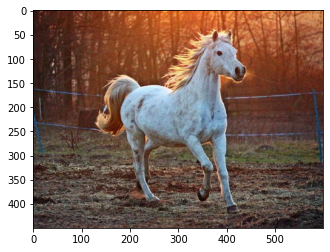

This Photo is of horse


In [22]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  img = mpimg.imread(fn)
  imgplot = plt.imshow(img)
  plt.show()
  if classes[0]>0.5:
    print("This Photo is of human")
  else:
    print("This Photo is of horse")

###Saving the  model


In [23]:
model.save("humanorhorse")

INFO:tensorflow:Assets written to: humanorhorse/assets
